In [1]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools 
from typing import Tuple

import torch

from torch.utils.data import Dataset, Sampler, DataLoader
from scipy import ndimage

import sys
sys.path.append("..")

from src.data.bridge_site import METADATA, TRAIN_DATA, get_dataloaders, DATA_ORDER

In [2]:
# correcting the file paths from ./data/[...] to ../data/[...]
metadata = dict(METADATA)
for country in metadata:
    md = metadata[country]
    for data_name in md:
        data = md[data_name]
        data["fp"] = os.path.join("../", data["fp"])

train_data = dict(TRAIN_DATA)
for version in train_data:
    for tile_size in train_data[version]:
        train_data[version][tile_size] = os.path.join(
            "../", train_data[version][tile_size])

# Dataloaders
This are all different dataloaders (different tile sizes, different versions)

In [5]:
# get dataloaders 1200m
(dataloader_train, dataloader_validation, dataloader_test,
 dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
    batch_size=64, tile_size=1200, train_data=train_data,
    train_metadata=metadata, transform=False, num_workers=0,
    stats_fp="../data/ground_truth/stats.json", use_augment=False,
    drop_last=False, data_version="v1"
)

# get dataloaders 600m
# (dataloader_train, dataloader_validation, dataloader_test,
#  dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
#     batch_size=64, tile_size=600, train_data=train_data,
#     train_metadata=metadata, transform=False, num_workers=0,
#     stats_fp="../data/ground_truth/stats.json", use_augment=False,
#     drop_last=False, data_version="v1"
# )

# get dataloaders 300m
# (dataloader_train, dataloader_validation, dataloader_test,
#  dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
#     batch_size=64, tile_size=300, train_data=train_data,
#     train_metadata=metadata, transform=False, num_workers=0,
#     stats_fp="../data/ground_truth/stats.json", use_augment=False,
#     drop_last=False, data_version="v1"
# )

# get dataloaders 1200m
# (dataloader_train, dataloader_validation, dataloader_test,
#  dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
#     batch_size=64, tile_size=1200, train_data=train_data,
#     train_metadata=metadata, transform=False, num_workers=0,
#     stats_fp="../data/ground_truth/stats.json", use_augment=False,
#     drop_last=False, data_version="v2"
# )

# get dataloaders 600m
# (dataloader_train, dataloader_validation, dataloader_test,
#  dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
#     batch_size=64, tile_size=600, train_data=train_data,
#     train_metadata=metadata, transform=False, num_workers=0,
#     stats_fp="../data/ground_truth/stats.json", use_augment=False,
#     drop_last=False, data_version="v2"
# )

# get dataloaders 300m
# (dataloader_train, dataloader_validation, dataloader_test,
#  dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
#     batch_size=64, tile_size=300, train_data=train_data,
#     train_metadata=metadata, transform=False, num_workers=0,
#     stats_fp="../data/ground_truth/stats.json", use_augment=False,
#     drop_last=False, data_version="v2"
# )

train sampler: 1630 samples in total (815 pos, 815 neg) ([Rwanda] 815 pos 815 neg [Uganda] 0 pos 0 neg)
val sampler: 484 samples in total (242 pos, 242 neg) ([Rwanda] 242 pos 242 neg [Uganda] 0 pos 0 neg)
test sampler: 1240 samples in total (620 pos, 620 neg) ([Rwanda] 370 pos 310 neg [Uganda] 250 pos 310 neg)
test sampler: 740 samples in total (370 pos, 370 neg) ([Rwanda] 370 pos 370 neg [Uganda] 0 pos 0 neg)
test sampler: 500 samples in total (250 pos, 250 neg) ([Rwanda] 0 pos 0 neg [Uganda] 250 pos 250 neg)


# Get data as numpy array
Feel free to save it as a temporary file and load it for speed up

In [10]:
# this is how to loop over the data and get numpy arrays
all_data = []
all_lab = []
for img, lab in dataloader_train:
    all_data.append(img)
    all_lab.append(lab)

all_data = torch.cat(all_data, 0).numpy()
all_lab = torch.cat(all_lab, 0).numpy()

print(all_data.shape)
# (1630, 9, 48, 48) -> 1630 instances, 9 channels, 48x48 tile pixels
print(all_lab.shape)
# (1630,)

(1630, 9, 48, 48)
(1630,)


In [7]:
# this is the order of 9 channels
dataloader_train.dataset.data_order

['population',
 'osm_img',
 'elevation',
 'slope',
 'roads',
 'waterways',
 'admin_bounds_qgis']

# Visualizations

## Augment vs non-augment

Text(0.5, 1.0, 'Admin bounds')

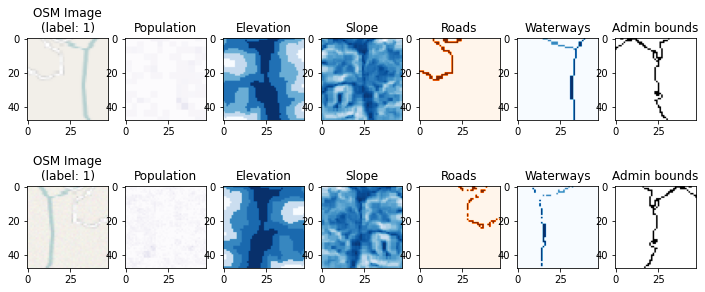

In [8]:
img, lab = dataloader_train.dataset[10]
img = dataloader_train.dataset.convert_tensor_2_numpy(img)

img_aug = copy.deepcopy(img)
img_aug = dataloader_train.dataset.augment(img_aug, rotate=False)

fig, axes = plt.subplots(2, 7, figsize=(12, 5))
axes[0, 0].imshow(img[:, :, 1:4].astype(int))
axes[0, 0].set_title("OSM Image\n(label: {})".format(lab))
axes[0, 1].imshow(
    img[:, :, 0:1].astype(int), vmin=0, vmax=100, cmap="Purples")
axes[0, 1].set_title("Population")
axes[0, 2].imshow(
    img[:, :, 4:5].astype(int), cmap="Blues")
axes[0, 2].set_title("Elevation")
axes[0, 3].imshow(
    img[:, :, 5:6].astype(int), cmap="Blues")
axes[0, 3].set_title("Slope")
axes[0, 4].imshow(
    img[:, :, 6:7].astype(int), cmap="Oranges")
axes[0, 4].set_title("Roads")
axes[0, 5].imshow(
    img[:, :, 7:8].astype(int), cmap="Blues")
axes[0, 5].set_title("Waterways")
axes[0, 6].imshow(
    img[:, :, 8:9].astype(int), cmap="Greys")
axes[0, 6].set_title("Admin bounds")

axes[1, 0].imshow(img_aug[:, :, 1:4].astype(int))
axes[1, 0].set_title("OSM Image\n(label: {})".format(lab))
axes[1, 1].imshow(
    img_aug[:, :, 0:1].astype(int), vmin=0, vmax=100, cmap="Purples")
axes[1, 1].set_title("Population")
axes[1, 2].imshow(img_aug[:, :, 4:5].astype(int), cmap="Blues")
axes[1, 2].set_title("Elevation")
axes[1, 3].imshow(img_aug[:, :, 5:6].astype(int), cmap="Blues")
axes[1, 3].set_title("Slope")
axes[1, 4].imshow(img_aug[:, :, 6:7].astype(int), cmap="Oranges")
axes[1, 4].set_title("Roads")
axes[1, 5].imshow(img_aug[:, :, 7:8].astype(int), cmap="Blues")
axes[1, 5].set_title("Waterways")
axes[1, 6].imshow(img_aug[:, :, 8:9].astype(int), cmap="Greys")
axes[1, 6].set_title("Admin bounds")

## labels 1 vs. 0, no augment

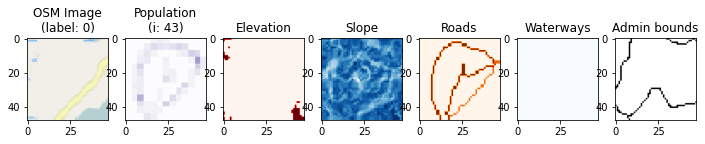

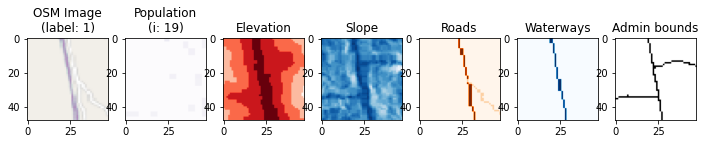

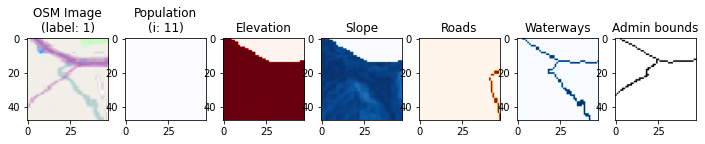

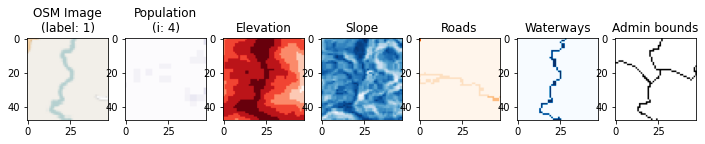

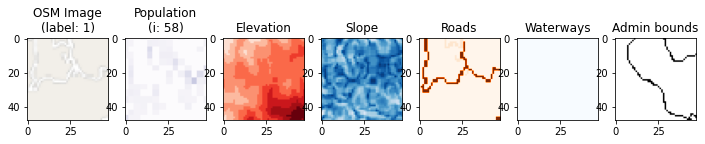

In [9]:
# label = 1 => bridge site, label = 0 => no bridge site
imgs, labs = next(iter(dataloader_train))
indeces = np.random.choice(len(imgs), 10, replace=False)

for j in range(5):
    i = indeces[j]
    img, lab = imgs[i], labs[i].numpy()
    img = dataloader_train.dataset.convert_tensor_2_numpy(img)
    fig, axes = plt.subplots(1, 7, figsize=(12, 20))
    
    axes[0].imshow(img[:, :, 1:4].astype(int))
    axes[0].set_title("OSM Image\n(label: {})".format(lab))
    axes[1].imshow(
        img[:, :, 0:1].astype(int), vmin=0, vmax=100, cmap="Purples")
    axes[1].set_title("Population\n(i: {})".format(i))
    axes[2].imshow(
        img[:, :, 4:5].astype(int), cmap="Reds")
    axes[2].set_title("Elevation")
    axes[3].imshow(
        img[:, :, 5:6].astype(int), cmap="Blues")
    axes[3].set_title("Slope")
    axes[4].imshow(
        img[:, :, 6:7].astype(int), cmap="Oranges")
    axes[4].set_title("Roads")
    axes[5].imshow(
        img[:, :, 7:8].astype(int), cmap="Blues")
    axes[5].set_title("Waterways")
    axes[6].imshow(
        img[:, :, 8:9].astype(int), cmap="Greys")
    axes[6].set_title("Admin bounds")